<a href="https://colab.research.google.com/github/andersonkstro/Meu-Portfolio/blob/master/Projeto_PrevisaoGastosplanosSaude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <a> Objeto de Estudo </a>

Vamos trabalhar com informações de planos de saúde! A área médica e de seguradoras de saúde utiliza muito as técnicas de ciência de dados e machine learning para avaliar risco dos seus segurados/pacientes. Vamos utilizar uma base de dados do livro ["Machine Learning with R"](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-r) de Brett Lantz, disponível [aqui](https://github.com/stedy/Machine-Learning-with-R-datasets).

O problema que queremos solucionar é prever os gastos com planos de saúde de acordo com as características do segurado. Poderia ser um problema interessante tanto para os segurados (para saber quais características tornam seu plano mais caro ou barato), quanto para seguradoras (para que mantenha suas contas equilibradas e saiba os segurados que devem ter um preço mais alto/baixo).


In [1]:
# importando as bibliotecas para leitura dos dados e criação de gráficos
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive


# configurando pandas para mostrar todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# configurando pandas para não mostrar notação científica para números
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# Ler os dados do seguro (internet)
from pandas import read_csv
arquivos = '/content/drive/MyDrive/1. Projetos/Portfólios/Regressão Linear - Projeto Prevendo Custo de Seguro de Vida/insurance.csv'
df_seguro = pd.read_csv(arquivos)
df_seguro.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [3]:
# Avaliando a quantidade de linhas e colunas
df_seguro.shape

(1338, 7)

In [4]:
# Avaliando os tipos
df_seguro.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
df_seguro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## <a> Começando com estatística descritiva </a>

Conhecer bem as medidas estatísticas, de tendência central, dispersão, separatrizes, distribuições, é essencial para conhecermos melhor os dados em que estamos trabalhando. Qual a distribuição da idade? Índice de massa corporal? E a variável target?

In [6]:
df_seguro.describe()

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


age = Idade
***
bmi - ínice de massa corporal
***
children = numero de filhos
***
charges = valor do plano de saúde

<Axes: xlabel='age', ylabel='Count'>

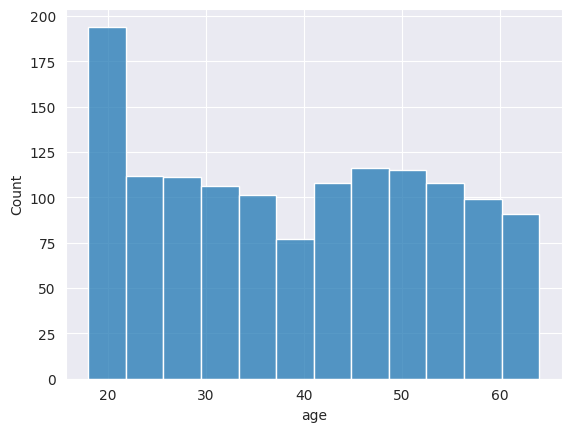

In [7]:
# Analisando a distribuição das idades
sns.set_style("darkgrid")
plt.tight_layout()
sns.histplot(data=df_seguro, x="age")

<Axes: xlabel='bmi', ylabel='Count'>

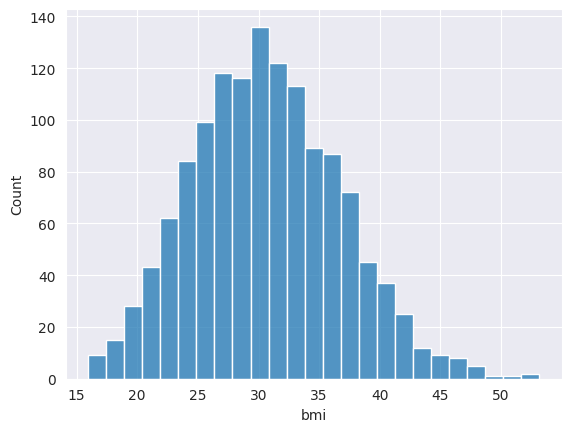

In [8]:
# Analisando as distribuições do índice de massa corporal
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df_seguro, x='bmi')

<Axes: xlabel='children', ylabel='count'>

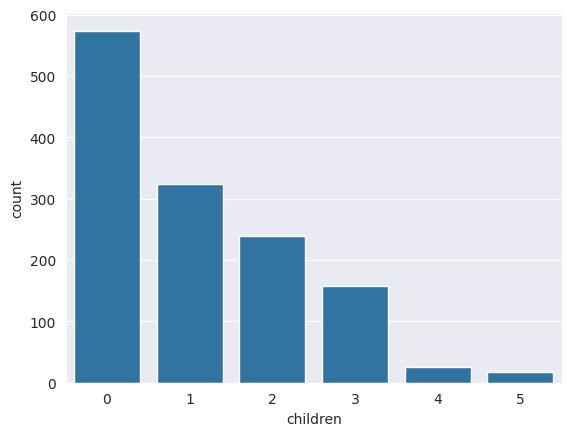

In [9]:
# Analisando as quantidades de crianças
sns.set_style("darkgrid")
plt.tight_layout()

sns.countplot(data=df_seguro, x='children')


<Axes: xlabel='charges', ylabel='Count'>

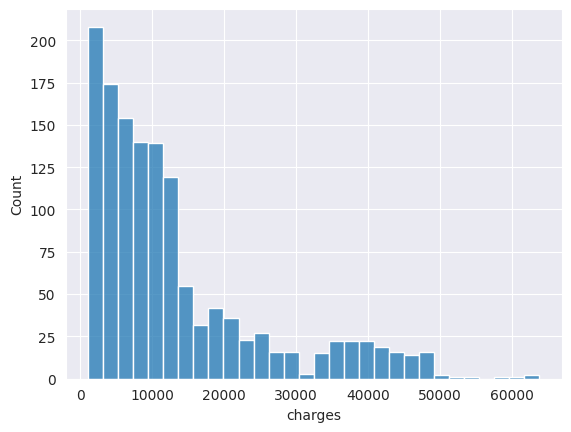

In [10]:
# Analisando a variável target: valor do seguro
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df_seguro, x="charges")

## <a> Relação entre as features e a variável target </a>

Uma análise interessante é avaliar relações entre as variáveis preditoras com a target. Vamos analisar as dispersões das variáveis preditoras com o valor do seguro.

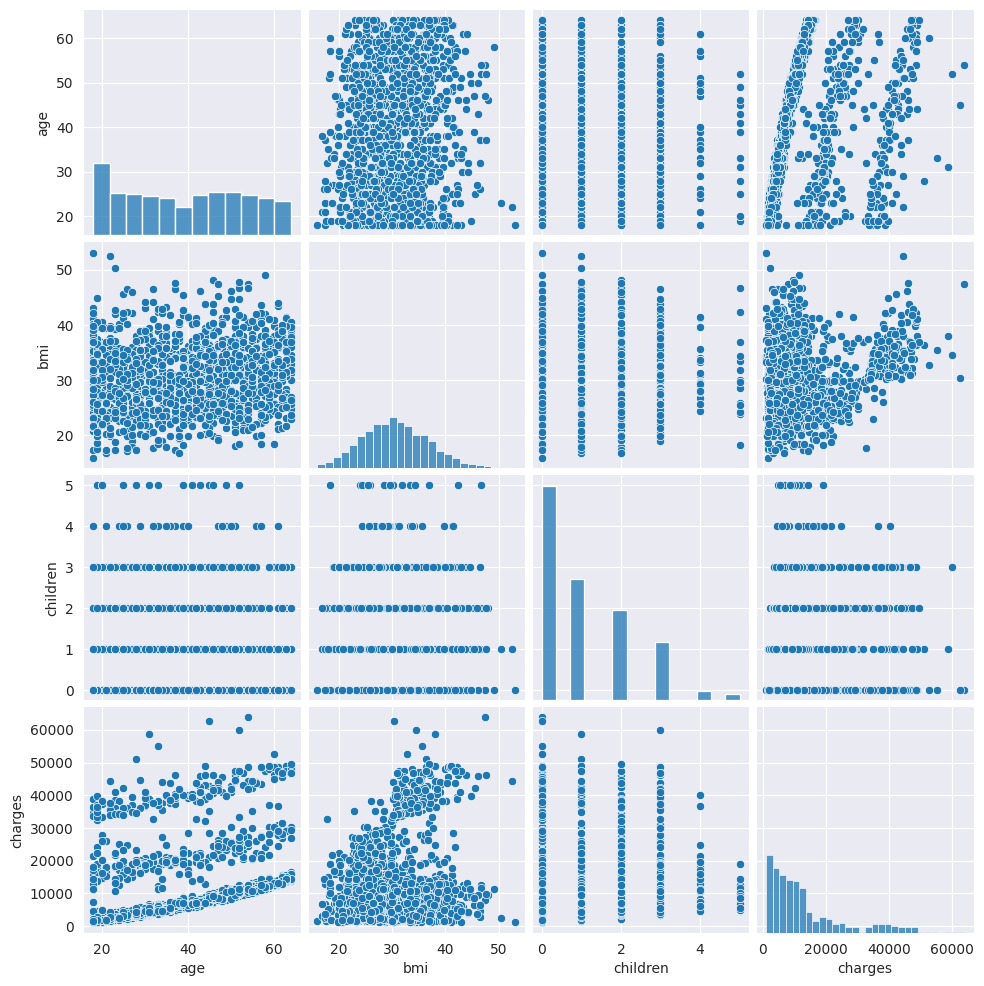

In [11]:
# O pairplot faz gráficos de dispersão para os pares de variáveis (incluindo a target)
# Na diagonal principal ele mostra o histograma
sns.pairplot(data=df_seguro)

Fica evidente uma correlação positiva entre idade e as cobranças de planos de saúde (age x charges). Provavelmente será uma variável de importância no modelo preditivo

## <a> Codificação de Variáveis Categóricas </a>

Lembrando que os modelos de machine learning não sabem o que são categorias em sua maioria, devemos, portanto, codificar as variáveis de sexo, fumante e localização.

In [12]:
df_seguro.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [13]:
# Como somente temos variáveis nominais, vamos utilizar One Hot Encoder
# Podemos utilizar o get_dummies do pandas, ou o OneHotEncoder do scikit learn
# Para variáveis somente com duas classes (sex e smoker), podemos fazer um mapeamento direto

df_seguro['female'] = df_seguro['sex'].map({'female': 1, 'male': 0})
df_seguro['smoker'] = df_seguro['smoker'].map({'yes': 1, 'no': 0})
df_seguro.head()

,age,sex,bmi,children,smoker,region,charges,female
0,19,female,27.90,0,1,southwest,16884.92,1
1,18,male,33.77,1,0,southeast,1725.55,0
2,28,male,33.00,3,0,southeast,4449.46,0
3,33,male,22.70,0,0,northwest,21984.47,0
4,32,male,28.88,0,0,northwest,3866.86,0


In [14]:
df_seguro = df_seguro.drop('sex', axis=1)
df_seguro.head()

,age,bmi,children,smoker,region,charges,female
0,19,27.90,0,1,southwest,16884.92,1
1,18,33.77,1,0,southeast,1725.55,0
2,28,33.00,3,0,southeast,4449.46,0
3,33,22.70,0,0,northwest,21984.47,0
4,32,28.88,0,0,northwest,3866.86,0


In [15]:
# 4 regiões
df_seguro['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

**Uma explicação sobre a bibliotca dummies que iremos usar logo abaixo**:
***
A função get_dummies do Pandas é utilizada para converter variáveis categóricas em variáveis dummy/indicadoras. Cada variável é transformada em variáveis 0/1, dependendo dos diferentes valores presentes. Os parâmetros dessa função incluem data (os dados a serem manipulados), prefix (string a ser anexada aos nomes das colunas), dummy_na (adicionar uma coluna para indicar NaNs), entre outros. O retorno da função é um DataFrame com os dados dummy-codificados. Essa função é essencial para lidar com dados categóricos de forma eficiente no Pandas *texto em itálico*

In [16]:
# Para as regiões vamos usar OHE
colunas_regiao = pd.get_dummies(df_seguro['region'], drop_first=True)
colunas_regiao.head()

,northwest,southeast,southwest
0,0,0,1
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0


In [17]:
# concat, concatena pandas dataframes, axis=1 ele junta colunas, axis=0 junta linhas
pd.concat([df_seguro, colunas_regiao], axis = 1).head()

,age,bmi,children,smoker,region,charges,female,northwest,southeast,southwest
0,19,27.90,0,1,southwest,16884.92,1,0,0,1
1,18,33.77,1,0,southeast,1725.55,0,0,1,0
2,28,33.00,3,0,southeast,4449.46,0,0,1,0
3,33,22.70,0,0,northwest,21984.47,0,1,0,0
4,32,28.88,0,0,northwest,3866.86,0,1,0,0


In [18]:
df_seguro = pd.concat([df_seguro, colunas_regiao], axis=1)
df_seguro = df_seguro.drop('region', axis=1)
df_seguro.head()

,age,bmi,children,smoker,charges,female,northwest,southeast,southwest
0,19,27.90,0,1,16884.92,1,0,0,1
1,18,33.77,1,0,1725.55,0,0,1,0
2,28,33.00,3,0,4449.46,0,0,1,0
3,33,22.70,0,0,21984.47,0,1,0,0
4,32,28.88,0,0,3866.86,0,1,0,0


## <a> Determinando quem são variáveis preditoras e variável target </a>

Ou... definindo X e y. É a forma mais usual de chamar as variáveis.

In [19]:
df_seguro.columns

Index(['age', 'bmi', 'children', 'smoker', 'charges', 'female', 'northwest',
       'southeast', 'southwest'],
      dtype='object')

In [20]:
X = df_seguro.drop('charges', axis=1) # tirando a variavel dependente
y = df_seguro[['charges']] # extraindo a variavel target

In [21]:
# Variáveis preditoras (ou independentes ou, features)
X.head()

,age,bmi,children,smoker,female,northwest,southeast,southwest
0,19,27.90,0,1,1,0,0,1
1,18,33.77,1,0,0,0,1,0
2,28,33.00,3,0,0,0,1,0
3,33,22.70,0,0,0,1,0,0
4,32,28.88,0,0,0,1,0,0


In [22]:
# Variável dependente, ou target
y.head()

,charges
0,16884.92
1,1725.55
2,4449.46
3,21984.47
4,3866.86


## <a> Separação de bases </a>

Separando as bases. Isso evita data leakage porque vamos fazer feature scaling, por exemplo, e tais transformações deve ser realizadas DEPOIS do split (separação).

In [23]:
# A função que separa nossa base em treino e teste!
# Lembrando que faremos cross validation com a base de treino
from sklearn.model_selection import train_test_split

# Devolve uma tupla com 4 elementos: X de treino, X de teste, y de treino, y de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, # preditoras
                                                        y, # target
                                                        test_size=.2,
                                                        random_state=42)

# Vamos ver quantas linhas ficamos com treino e teste
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((1070, 8), (268, 8), (1070, 1), (268, 1))

## <a> Feature Scaling </a>

**Como usaremos pelo menos um modelo linear, é importante realizar scaling das features para mantê-las numa mesma escala de grandeza. Vamos de MinMaxScaler?**
***
Consiste em ajustar as escalas das variáveis independentes (features) para que todas estejam em um intervalo específico, evitando que diferenças nas escalas impactem negativamente nos algoritmos de aprendizado de máquina. Nesse modelo usaremos a função normalização Min-Max e a padronização (Z-score). A normalização Min-Max redimensiona os valores para um intervalo fixo, geralmente entre 0 e 1, preservando a forma da distribuição original. *texto em itálico*

In [24]:
df_seguro.describe()

,age,bmi,children,smoker,charges,female,northwest,southeast,southwest
count,1338.00,1338.00,1338.00,1338.00,1338.00,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,0.20,13270.42,0.49,0.24,0.27,0.24
std,14.05,6.10,1.21,0.40,12110.01,0.50,0.43,0.45,0.43
min,18.00,15.96,0.00,0.00,1121.87,0.00,0.00,0.00,0.00
25%,27.00,26.30,0.00,0.00,4740.29,0.00,0.00,0.00,0.00
50%,39.00,30.40,1.00,0.00,9382.03,0.00,0.00,0.00,0.00
75%,51.00,34.69,2.00,0.00,16639.91,1.00,0.00,1.00,0.00
max,64.00,53.13,5.00,1.00,63770.43,1.00,1.00,1.00,1.00


In [25]:
# Normalização - MinMaxScaler, Padronização - StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Criar scaler
scaler = MinMaxScaler()

In [26]:
type(scaler)

sklearn.preprocessing._data.MinMaxScaler

In [27]:
scaler

MinMaxScaler()

In [28]:
colunas = X_treino.columns

# Parte importante!! Fit no treino! Transform no treino e teste
X_treino[colunas] = scaler.fit_transform(X_treino)
X_teste[colunas] = scaler.transform(X_teste)

X_treino.shape, X_teste.shape

((1070, 8), (268, 8))

In [29]:
X_treino.head()

,age,bmi,children,smoker,female,northwest,southeast,southwest
560,0.61,0.11,0.40,0.00,1.00,1.00,0.00,0.00
1285,0.63,0.22,0.00,0.00,1.00,0.00,0.00,0.00
1142,0.74,0.24,0.00,0.00,1.00,0.00,1.00,0.00
969,0.46,0.49,1.00,0.00,1.00,0.00,1.00,0.00
486,0.78,0.15,0.60,0.00,1.00,1.00,0.00,0.00


In [30]:
X_treino.describe()

,age,bmi,children,smoker,female,northwest,southeast,southwest
count,1070.00,1070.00,1070.00,1070.00,1070.00,1070.00,1070.00,1070.00
mean,0.46,0.39,0.22,0.21,0.49,0.24,0.26,0.25
std,0.31,0.16,0.24,0.40,0.50,0.43,0.44,0.43
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.20,0.28,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.47,0.38,0.20,0.00,0.00,0.00,0.00,0.00
75%,0.72,0.50,0.40,0.00,1.00,0.00,1.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## <a> Analisando a correlação entre variáveis </a>

Quando utilizamos modelos lineares, é importante saber se as variáveis preditoras guardam alguma colinearidade. Caso ocorra, devemos remover uma das variáveis para que o modelo não seja afetado.

<Axes: >

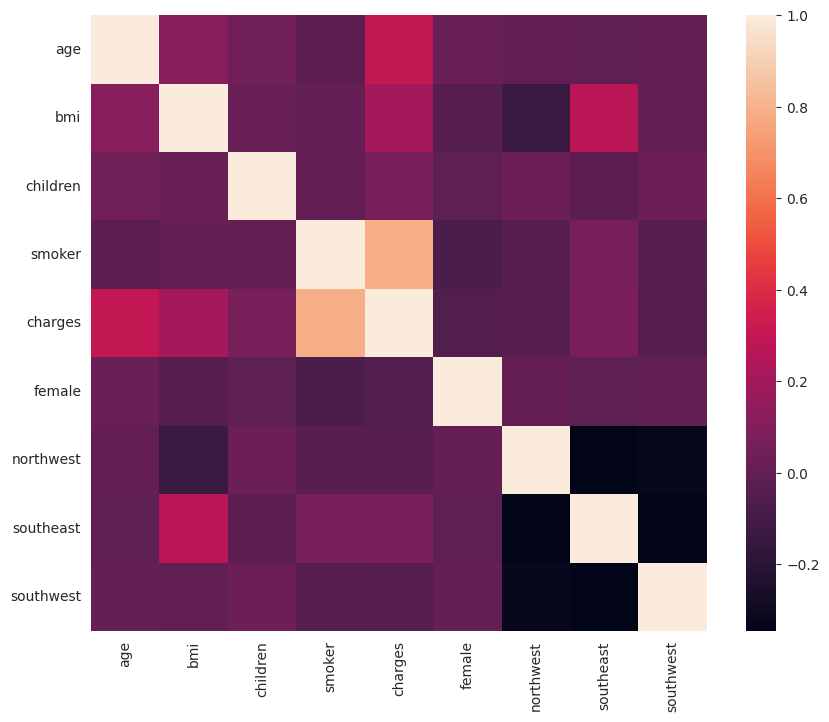

In [31]:
figura, graficos = plt.subplots(figsize=(10, 8))
corr = df_seguro.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            square=True, ax=graficos)

## <a> Analisando se existem dados faltantes </a>

In [32]:
df_seguro.isnull().sum()

age          0
bmi          0
children     0
smoker       0
charges      0
female       0
northwest    0
southeast    0
southwest    0
dtype: int64

## <a> Vamos de Machine Learning? </a>

Primeiro modelo que vamos treinar é a regressão linear. Lembrando que vamos utilizar cross validation para evitar overfit e ter uma base de comparação para outros modelos

In [33]:
from sklearn.linear_model import LinearRegression # regressão linear
from sklearn.model_selection import cross_val_score # calcular metricas e selecionar modelos

In [34]:
# Criando o estimador, algorimo, modelo, preditor, regressor (virge, que tanto de nome!)
regressao_linear = LinearRegression()

# Vamos treinar utilizando cross validation
valores_rmse_rl = cross_val_score(estimator=regressao_linear, # algoritimo de aprendizado
                                  X=X_treino,
                                  y=y_treino,
                                  cv=10, # 10-fold CV - separar em 10 partes
                                  scoring='neg_root_mean_squared_error') # erro médio quadrado
valores_rmse_rl

array([-6073.99997254, -6580.87166754, -5233.82683473, -6045.25239632,
       -5836.4647871 , -6127.43525895, -7281.08373608, -6321.52706355,
       -6193.3145481 , -5637.06299714])

In [35]:
len(valores_rmse_rl)

10

In [36]:
valores_rmse_rl = valores_rmse_rl * -1
valores_rmse_rl

array([6073.99997254, 6580.87166754, 5233.82683473, 6045.25239632,
       5836.4647871 , 6127.43525895, 7281.08373608, 6321.52706355,
       6193.3145481 , 5637.06299714])

In [37]:
valores_rmse_rl = valores_rmse_rl.mean()
valores_rmse_rl

6133.0839262055

### Vamos tentar agora uma árvore de regressão?

In [38]:
from sklearn.tree import DecisionTreeRegressor

arvore_regressao = DecisionTreeRegressor()

# Vamos treinar utilizando cross validation (sempre!!)
valores_rmse_arvore = cross_val_score(estimator=arvore_regressao,
                                      X=X_treino,
                                      y=y_treino,
                                      cv=10, #
                                  scoring='neg_root_mean_squared_error')
valores_rmse_arvore

array([-6258.19720938, -7651.32979227, -6964.8613286 , -6464.39139142,
       -7482.70065873, -5759.6909836 , -7558.44229698, -6463.23262133,
       -6637.89385135, -5952.22904927])

In [39]:
valores_rmse_arvore = valores_rmse_arvore * -1
valores_rmse_arvore

array([6258.19720938, 7651.32979227, 6964.8613286 , 6464.39139142,
       7482.70065873, 5759.6909836 , 7558.44229698, 6463.23262133,
       6637.89385135, 5952.22904927])

In [40]:
valores_rmse_arvore = valores_rmse_arvore.mean()
valores_rmse_arvore

6719.29691829268

### E se retiramos as colunas de regiões. Na análise de correlação elas não mostraram muita influência na variável target

In [41]:
X_treino.columns

Index(['age', 'bmi', 'children', 'smoker', 'female', 'northwest', 'southeast',
       'southwest'],
      dtype='object')

In [42]:
# Vamos treinar utilizando cross validation (sempre!!)
colunas_regiao = ['northwest', 'southeast', 'southwest']
valores_rmse_rl_sem_regiao = cross_val_score(estimator=regressao_linear,
                                             X=X_treino.drop(colunas_regiao, axis=1),
                                             y=y_treino,
                                             cv=10,
                                      scoring='neg_root_mean_squared_error')
valores_rmse_rl_sem_regiao.mean() * -1

6121.545062597132

In [43]:
# Fazendo a conversão
valores_rmse_rl_sem_regiao = valores_rmse_rl_sem_regiao * -1
valores_rmse_rl_sem_regiao

array([6047.74861144, 6576.17442833, 5208.18399508, 5969.09583538,
       5870.19697933, 6107.50898187, 7295.03885205, 6309.72867769,
       6178.86188095, 5652.91238386])

In [44]:
# Vamos treinar utilizando cross validation (sempre!!)
colunas_regiao = ['northwest', 'southeast', 'southwest']
valores_rmse_arvore_sem_regiao= cross_val_score(estimator=arvore_regressao,
                                             X=X_treino.drop(colunas_regiao, axis=1),
                                             y=y_treino,
                                             cv=10,
                                      scoring='neg_root_mean_squared_error')
valores_rmse_arvore_sem_regiao.mean() * -1

6795.128854567575

In [45]:
valores_rmse_arvore_sem_regiao = valores_rmse_arvore_sem_regiao * -1
valores_rmse_arvore_sem_regiao

array([6166.94385989, 6732.55843293, 6126.16180232, 6583.16888471,
       6774.27746058, 6779.85134283, 7853.45348246, 7148.30748422,
       6994.03675437, 6792.52904137])

Text(0.5, 1.0, 'Comparação de RMSE')

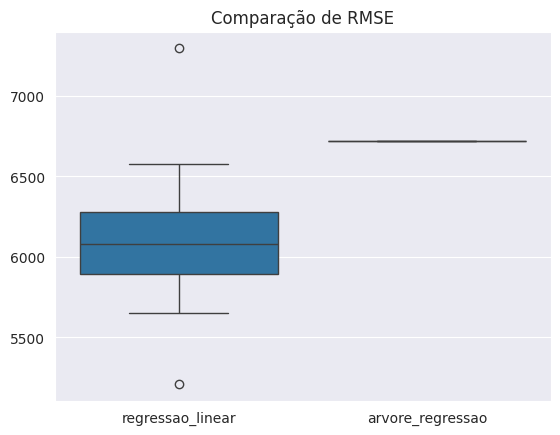

In [46]:
rmse = pd.DataFrame({'regressao_linear': valores_rmse_rl_sem_regiao, 'arvore_regressao': valores_rmse_arvore})

sns.boxplot(data=rmse).set_title("Comparação de RMSE")

## <a> Modelo Campeão! </a>

Agora que temos um modelo campeao, vamos treinar modelo na base de treinamento toda!


In [47]:
regressao_linear.fit(X_treino.drop(colunas_regiao, axis=1), y_treino)

LinearRegression()

In [48]:
regressao_linear.coef_

array([[1.18251723e+04, 1.21744207e+04, 2.13627215e+03, 2.36539033e+04,
        7.95178837e+00]])

In [49]:
df_coeficientes = pd.DataFrame(regressao_linear.coef_)
df_coeficientes.columns=regressao_linear.feature_names_in_
df_coeficientes

,age,bmi,children,smoker,female
0,11825.17,12174.42,2136.27,23653.90,7.95


Os coeficientes representam o seguinte:
***
Para cada ano de age(idade), aumentam 11 mil dólares no plano de saúde. Para cada bmi(indice corporal), aumentam 12 mil dólares.. etc

In [50]:
# Extra: podemos calcular o p-valor dos coeficientes de cada regressão utilizando o pacote statsmodels
import statsmodels.api as sm

rl_statsmodels = sm.OLS(y_treino,X_treino.drop(colunas_regiao, axis=1))
resultado_fit = rl_statsmodels.fit()
p_valores = resultado_fit.summary2().tables[1]['P>|t|']
p_valores

age        0.00
bmi        0.00
children   0.07
smoker     0.00
female     0.21
Name: P>|t|, dtype: float64

## <a> Concluindo </a>

Agora que temos nosso modelo final, podemos fazer inferências dos valores do plano de saúde no TESTE. Até o momento não utilizamos o teste PARA NADA, como deve ser.

ou seja, os coeficientes para crianças e sexo não são estatisticamente válidos, devemos ter cautela ao analisar o impacto nos valores do plano de saúde. Mas idade, índice de massa corporal e se a pessoa fuma ou não, estão liberados para usar, falando estatiticamente.

In [51]:
# ver estimadores scikit learn
# estimador é treinado com fit
# estimador prediz com predict
precos_preditos = regressao_linear.predict(X_teste.drop(colunas_regiao, axis=1))
precos_preditos[:5]

array([[ 8554.81711589],
       [ 6973.58746745],
       [36798.60416104],
       [ 9417.88282303],
       [26871.68031081]])

In [52]:
len(precos_preditos)

268

In [53]:
y_teste.head()

,charges
764,9095.07
887,5272.18
890,29330.98
1293,9301.89
259,33750.29


In [54]:
predicoes_vs_real = pd.DataFrame({'predicao': precos_preditos.flatten(), 'real': y_teste.values.flatten()})
predicoes_vs_real['diferenca_abs'] = abs(predicoes_vs_real['predicao'] - predicoes_vs_real['real'])
predicoes_vs_real.head(20)

,predicao,real,diferenca_abs
0,8554.82,9095.07,540.25
1,6973.59,5272.18,1701.41
2,36798.60,29330.98,7467.62
3,9417.88,9301.89,115.99
4,26871.68,33750.29,6878.61
5,11097.38,4536.26,6561.12
6,145.28,2117.34,1972.06
7,16746.17,14210.54,2535.63
8,747.53,3732.63,2985.09
9,11153.68,10264.44,889.23


In [55]:
# Mas será que uma simples média é melhor do
# que nosso modelo? Vamos testar o r quadrado
from sklearn.metrics import r2_score

r2_score(y_true=y_teste, y_pred=precos_preditos)

0.7811302113434095

0,78 nosso modelo explica bastante a variável target

#### Testando uma predição com nossos inputs?

In [56]:
X_teste.drop(colunas_regiao, axis=1).columns

Index(['age', 'bmi', 'children', 'smoker', 'female'], dtype='object')

In [58]:
idade = input()

39


In [59]:
indice_massa_corporal = input()

30


In [60]:
criancas = input()

0


In [74]:
fumante = input("1 para fumante e 0 para não fumante:")

1 para fumante e 0 para não fumante:0


In [62]:
sexo = input()

0


In [63]:
idade, indice_massa_corporal, criancas, fumante, sexo

('39', '30', '0', '0', '0')

In [75]:
# Realizando scaling das features
#scaler_sem_regiao = MinMaxScaler()
#scaler_sem_regiao.fit(X_treino.drop(colunas_regiao, axis=1))

# Completamos com 1,1,1 porque o X_treino original tinha colunas de região
features = [[idade, indice_massa_corporal, criancas, fumante, sexo, 1, 1, 1]]

# O scaler é do treino (nada de fitar de novo)
features = scaler.transform(features)
features

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.45652174, 0.37772397, 0.        , 0.        , 0.        ,
        1.        , 1.        , 1.        ]])

In [76]:
features

array([[0.45652174, 0.37772397, 0.        , 0.        , 0.        ,
        1.        , 1.        , 1.        ]])

In [77]:
# Pegando somente as 5 features
features = features[:,:-3]
features

array([[0.45652174, 0.37772397, 0.        , 0.        , 0.        ]])

In [73]:
# Resultado da predição - FUMANTE
regressao_linear.predict(features)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[31384.19521039]])

In [79]:
# Resultado da predição - NÃO FUMANTE
regressao_linear.predict(features)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[7730.29189565]])

O **fumante**, o indivíduo pagará 31.384,00 dólares no plano por ano.
***
O **não fumante**, pagará 7.730,00 dólares no plano por ano